<a href="https://colab.research.google.com/github/Katona-lab/MST-anlysis/blob/main/MST_progress_curve_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
#@title Start here by selecting Excel MST file exported by the Nanotemper software
#@markdown Please cite this article: <br>
#@markdown Atsarina Larasati Anindya, Maria-Jose Garcia-Bonete, Maja Jensen, Christian V. Recktenwald, Maria Bokarewa and Gergely Katona <i>Bayesian Progress Curve Analysis of MicroScale Thermophoresis Data.</i>
#@markdown (2022) <b><i>Digital discovery</i></b>
# (c) 2022 Gergely Katona <gergely.katona@gu.se>
import io
import pandas as pd
from google.colab import files
import numpy as np
import pymc3 as pm
import pylab as plt
import theano.tensor as T
from pymc3.math import switch

#Experimental data description 
uploaded = files.upload()

df=pd.read_excel(io.BytesIO(uploaded[list(uploaded.keys())[0]]))

ligpos=df.loc[df.iloc[:,0] == 'Ligand Concentration:'].index[0]
firsttimepos=df.loc[df.iloc[:,0] == 'Time [s]'].index[0]
targind=df.loc[df.iloc[:,0] == 'TargetConcentration:'].index[0]
FluoConc=df.iloc[targind,1]

cideal=df.iloc[ligpos,1::3]
onedtime=df.iloc[firsttimepos+1:,0].reset_index(drop=True)
firstIRtimepos=onedtime.loc[onedtime==0].index[0]
fluorescence=df.iloc[firsttimepos+1:,1::3].reset_index(drop=True)
fluorescence=fluorescence.T.reset_index(drop=True).T
Capillary=len(cideal)
start_t=onedtime.iloc[0]
end_t=onedtime.iloc[-1]
print ("The data start at position %i, which corresponds to %f s." % (0,start_t))
print ("The data ends at position %i, which corresponds to %f s." % (len(onedtime),end_t))
print ("The IR laser is supposed to be ON from position %i, which corresponds to 0 s."% (firstIRtimepos))
print ("The target concentration is %E ."% FluoConc)
print ("%i capillaries were used" % Capillary)
print ("The ligand concentrations are %s ."% list(cideal))
print ("Units hopefully agree and the KD will be expressed in the same unit.")

Saving Calciumdata.xlsx to Calciumdata (2).xlsx
The data start at position 0, which corresponds to -3.576749 s.
The data ends at position 341, which corresponds to 21.758556 s.
The IR laser is supposed to be ON from position 48, which corresponds to 0 s.
The target concentration is 3.000000E-08 .
The ligand concentrations are [3.0517578125e-08, 6.103515625e-08, 1.220703125e-07, 2.44140625e-07, 4.8828125e-07, 9.765625e-07, 1.953125e-06, 3.90625e-06, 7.8125e-06, 1.5625e-05, 3.125e-05, 6.25e-05, 0.000125, 0.00025, 0.0005, 0.001] .
Units hopefully agree and the KD will be expressed in the same unit.


In [12]:
#@title Displaying and verifying the data. Adjusting data range and laser start. { run: "auto" }
import ipywidgets as widgets
from IPython.display import display
#@markdown Step 1: Inspect the progress curve. Is this the data you want to model? The program tries to guess a suitable end point automatically. This initial guess will vary from capillary to capillary, but once you start modelling the last displayed end data point will be used for for all capillaries. Please feel free to override data range according to your wishes.<p>
#@markdown Step 2: Zoom in with the sliders to the laser start point and adjust to the point where the Fnorm starts to drop rapidly. Experience shows that there is a few ms delay between time 0 of the instrument and first sign of response in Fnorm. An empirical delay is already automatically applied to laser start.<p>
#@markdown Step 3: Reset the end slider to the end of the IR irradiation period or any point earlier. The model does not take into account the recovery phase after the IR laser is swiched off.
Capillary = "16" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]

Data_range=widgets.IntRangeSlider(
    value=[0, fluorescence[int(Capillary)-1].astype(float).idxmin()],
    min=0,
    max=len(onedtime),
    step=1,
    description='Data_range:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

Start_pos=widgets.IntSlider(
    value=0,
    min=0,
    max=len(onedtime),
    step=1,
    description='Start_pos:',
    disabled=False
)

End_pos=widgets.IntSlider(
    value=len(onedtime),
    min=0,
    max=len(onedtime),
    step=1,
    description='End_pos:',
    disabled=False
)

IR_pos=widgets.IntSlider(
    value=firstIRtimepos,
    min=0,
    max=len(onedtime),
    step=1,
    description='IR_pos:',
    disabled=False
)

def f(Data_range, IR_pos):
    Start_pos,End_pos=Data_range
    fig, ax = plt.subplots()
    ax.plot(onedtime[Start_pos:End_pos],fluorescence[int(Capillary)-1].astype(float).iloc[Start_pos:End_pos], color='gray')
    ax.annotate('IR laser', 
            xy=(onedtime[IR_pos], 1), 
            xytext=(onedtime[IR_pos], 0.95), 
            arrowprops = dict(facecolor='red', shrink=0.05)
    )
    plt.xlabel ("Time (s)")
    plt.ylabel (r"$F_{norm}$")
out = widgets.interactive_output(f, {'Data_range': Data_range, 'IR_pos': IR_pos})

widgets.HBox([widgets.VBox([Data_range, IR_pos]), out])









In [13]:
#@title Alternative 1: Perform the MCMC sampling (linear phase starts before the IR irradiation)
#@markdown Use scenario: The fluroescence signal (Fnorm) is not stable at 1 before IR irradiation. Possible reasons: photodamage, unstable protein, not fully equilibrated protein:ligand interaction

##@markdown Enter labeled protein concentration in units of nM:
#FluoConc =  20#@param {type:"number"}
##@markdown Enter the number of capillaries used in the experiment. The concentration of the ligand will be infered from the data file.
#Capillary = "16" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]

IR=IR_pos.value
start,end=Data_range.value
cap=int(Capillary)
time=np.array([onedtime[:,]]*cap,dtype=float).transpose()
with pm.Model() as model:
    K_D = pm.Uniform('K_D', 1, 1e6)
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1e8)
    c_fl = BoundedNormal('c_fl',mu=FluoConc,sd=FluoConc/10.0)

    U=pm.Beta('U',alpha=1,beta=1)
    B=pm.Beta('B',alpha=1,beta=1)
    A_total=pm.Deterministic('A_total', U + (B-U)*((c_fl + cideal.astype(float) + K_D - pm.math.sqrt(pm.math.sqr(c_fl + cideal.astype(float) + K_D) - 4.0*c_fl*cideal.astype(float)))/(2*c_fl)))
    
    L=pm.Uniform('L',-1,1, shape=cap)
    I=pm.Deterministic('I',1+L*start_t-A_total)
    R=pm.Beta('R',alpha=2,beta=1, shape=cap)
    A_1=pm.Deterministic('A_1',A_total*R)
    A_2=pm.Deterministic('A_2',A_total*(1-R))
    rate1=pm.Lognormal('rate1',0,1, shape=cap)
    rate2=pm.Lognormal('rate2',0,1, shape=cap)

    linearphase=L*(time-start_t)
    E_1=A_1*pm.math.exp(-1.0*rate1*time)
    E_2=A_2*pm.math.exp(-1.0*rate2*time)

    epsilon = pm.Lognormal('epsilon', 0, 1)
    laseron=np.tile(np.arange(0, len(onedtime)), (cap,1)).T

    pr = switch(IR >= laseron, 1.0+linearphase, linearphase+I+E_1+E_2)


    P = pm.Normal('P', mu=pr[start:end], sd=epsilon, observed=fluorescence.astype(float).iloc[start:end])


with model:
    trace = pm.sampling.sample(200, tune=100,
                      init='ADVI'
                     )
    
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=1000 ,model=model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 119200
Interrupted at 119,199 [59%]: Average Loss = 3.6928e+30
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, rate2, rate1, R, L, B, U, c_fl, K_D]


Sampling 2 chains for 100 tune and 200 draw iterations (200 + 400 draws total) took 206 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [ ]:
#@title Alternative 2: Perform the MCMC sampling (linear phase starts at time 0)
#@markdown Use scenario: Fnorm is stable at 1 before IR irradiation, but after irradiation there is a trendlike increase or decrease in at least some of the progress curves. Possible causes: temperature induced denaturation, direct IR absorption in protein results in electrodynamic interaction between protein and ligand.

#@markdown Enter labeled protein concentration in units of nM:
FluoConc =  20#@param {type:"number"}
#@markdown Enter the number of capillaries used in the experiment. The concentration of the ligand will be infered from the data file.
Capillary = "16" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]

cap=int(Capillary)
time=np.array([onedtime[:,]]*cap,dtype=float).transpose()
with pm.Model() as model:
    Kd = pm.Uniform('Kd', 1, 1e6)
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1e8)
    FC = BoundedNormal('FC',mu=FluoConc,sd=FluoConc/10.0)

    ampunbound=pm.Beta('ampunbound',alpha=1,beta=1)
    ampbound=pm.Beta('ampbound',alpha=1,beta=1)
    totalamp=pm.Deterministic('totalamp', ampunbound + (ampbound-ampunbound)*((FC + cideal.astype(float) + Kd - pm.math.sqrt(pm.math.sqr(FC + cideal.astype(float) + Kd) - 4.0*FC*cideal.astype(float)))/(2*FC)))

    
    linslope=pm.Uniform('linslope',-1,1, shape=cap)
    level=pm.Deterministic('level',1-totalamp)
    ampfract=pm.Beta('ampfract',alpha=2,beta=1, shape=cap)
    amp1=pm.Deterministic('amp1',totalamp*ampfract)
    amp2=pm.Deterministic('amp2',totalamp*(1-ampfract))
    rate1=pm.Lognormal('rate1',0,1, shape=cap)
    rate2=pm.Lognormal('rate2',0,1, shape=cap)

    linearphase=linslope*(time)
    expcomp1=amp1*pm.math.exp(-1.0*rate1*time)
    expcomp2=amp2*pm.math.exp(-1.0*rate2*time)

    sigma = pm.Lognormal('sigma', 0, 1)
    laseron=np.tile(np.arange(0, 543), (cap,1)).T

    pr = switch(75 >= laseron, 1.0, linearphase+level+expcomp1+expcomp2)


    pred = pm.Normal('pred', mu=pr[0:475], sd=sigma, observed=fluorescence.astype(float).iloc[0:475])


with model:
    trace = pm.sampling.sample(2000, tune=1000,
                      init='ADVI'
                     )
    
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=1000 ,model=model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 66200
Interrupted at 66,199 [33%]: Average Loss = 1.4816e+13
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, rate2, rate1, ampfract, linslope, ampbound, ampunbound, FC, Kd]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 3763 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [14]:
#@title Statistics of global variables
#@markdown Kd and FC units are traditionally expressed in nM in the Nanotemper software, the amplitudes and sigma is expressed as Fnorm  
pm.stats.summary(trace,var_names=['K_D','B','U', 'epsilon','c_fl'])


Got error No model on context stack. trying to find log_likelihood in translation.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
K_D,552277.210,275710.566,87746.140,993074.267,32560.283,23117.906,77.0,163.0,1.01
B,0.499,0.279,0.036,0.916,0.041,0.029,48.0,110.0,1.02
U,0.063,0.000,0.063,0.063,0.000,0.000,4.0,17.0,1.40
epsilon,0.001,0.000,0.001,0.001,0.000,0.000,70.0,97.0,1.03
c_fl,0.000,0.000,0.000,0.000,0.000,0.000,57.0,97.0,1.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  import sys


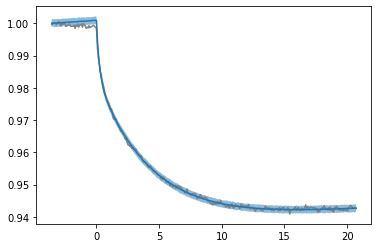

In [36]:
#@title Posterior predictive check { run: "auto" }
#@markdown Choose the capillary to analyse:
Capillary = "1" #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]

plt.plot(onedtime[start:end],fluorescence[int(Capillary)-1].astype(float).iloc[start:end], color='gray')
plt.plot(onedtime[start:end],np.mean(ppc['P'][:,:,int(Capillary)-1], axis=0))
plt.fill_between(np.array(onedtime[start:end],dtype=float), np.array(pm.stats.hdi(ppc['P'][:,:,int(Capillary)-1])[:,0],dtype=float) ,np.array(pm.stats.hdi(ppc['P'][:,:,int(Capillary)-1])[:,1],dtype=float) , alpha=0.5)


In [ ]:
fluorescence

,NanoTemper Technologies.1,Unnamed: 4,Unnamed: 7,Unnamed: 10,Unnamed: 13,Unnamed: 16,Unnamed: 19,Unnamed: 22,Unnamed: 25,Unnamed: 28,Unnamed: 31,Unnamed: 34,Unnamed: 37,Unnamed: 40,Unnamed: 43,Unnamed: 46
0,1.001723,0.997642,1.000468,0.997507,0.998625,0.997517,1.000453,0.999429,0.999199,0.999144,1.000779,0.9994,0.997883,0.999281,0.999722,1.001121
1,0.999152,1.001489,0.998536,0.999687,1.001364,1.001993,0.998387,1.001346,1.00189,0.998562,1.000301,0.998452,1.000142,1.000299,0.999014,0.999616
2,1.001331,1.000538,1.000017,1.001528,1.002331,1.001108,0.99825,1.00008,0.996793,0.999876,0.999912,0.999081,1.000335,0.997249,1.001848,1.003206
3,0.999283,1.000956,1.000546,1.000831,0.997973,0.999157,1.00218,1.00029,1.000345,0.998692,1.002187,1.000256,0.999698,0.999508,1.000812,0.998571
4,1.002078,0.998798,0.998863,1.002002,0.998903,1.001125,1.002892,1.001704,0.998551,0.999767,0.998391,1.000572,1.000867,0.998522,1.000259,0.998662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,0.896745,0.900451,0.899821,0.898078,0.898737,0.899341,0.904167,0.90282,0.934527,0.908036,0.908358,0.907624,0.90825,0.909877,0.914866,0.91249
539,0.898365,0.898314,0.901775,0.898775,0.896349,0.898173,0.902757,0.905427,0.936075,0.907212,0.909811,0.907789,0.910408,0.910548,0.916074,0.917994
540,0.901988,0.903488,0.901732,0.897996,0.899176,0.89912,0.903672,0.90555,0.93834,0.908355,0.911661,0.911626,0.91199,0.911194,0.915839,0.91767
541,0.901858,0.902229,0.904231,0.902132,0.899535,0.899649,0.906314,0.905715,0.939989,0.911096,0.911557,0.911923,0.912441,0.912533,0.916944,0.916911


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  


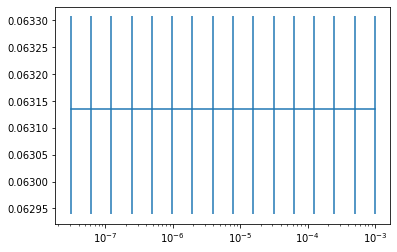

In [44]:
#@title Concentration dependence of the kinetic parameters. { run: "auto" }

#@markdown Choose the variable name:
string = "A_total" #@param ["A_total","I", "rate1", "rate2", "A_1", "A_2", "L"]
fig=plt.subplot(111)
plt.errorbar(cideal,np.median(trace[string],axis=0),yerr=np.abs(pm.hdi(trace[string]).T-np.median(trace[string],axis=0)))
fig.set_xscale('log')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  


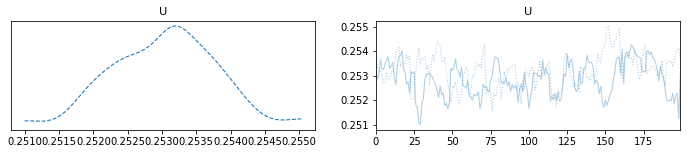

In [ ]:
#@title Posterior distribution of model parameters. { run: "auto" }

#@markdown Choose the variable name:
string = "U" #@param ["K_D","B","U","epsilon","A_total","I", "rate1", "rate2", "A_1", "A_2", "L"]
with model:
  ax=pm.traceplot(trace[0:],[string],combined=True)